In [1]:
# !pip install -r requirements.txt

In [2]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

## The Problem Statement

In this test, we are going to solve the problem regarding Sanctions Scanning. We are provided with transaction data, and there are names and entities appearing in those transactions that need to be screened and flagged if they match the sanction list.

The machine learning problem is to find a robust method to scan the transaction data and identify potential matches with high precision compared to traditional methods.

The real problem is that traditional methods often end up with many false positives, which are not efficient and cause a lot of costs to financial institutions.

The aim of the machine learning method is to help reduce those false positives using cutting-edge techniques.

In order to solve the problem, we need good test data to cover different scenarios and be a good representation of real-world situations.

I have generated synthetic data using ChatGPT 4.0 combined with my engineering, and the final input is as follows:

    - Generated by CahtGpt 4O 
    - It Contains 1200 rows of data containing Names and Text to be Scanned
    - Generated sanction list of names with 260 names in Total. 
    
  Example:
  
            Here’s an example of a legitimate match:
            
            Scanned text: GB12345678 smith, jon 23 Liverpool street
            Matched entity: John Michael Smith
             
            As you can see, part of the challenge is the transaction may have irrelevant text in the beginning or end. The other challenge is the    varied nature of how names are written. Here are some examples of variations:
            
            Different Spelling -> Jon vs John
            Typos
            Swapped first and last names
            Initials -> John Smith vs J Smith
            Unnatural Spacing -> j o h n
            No spaces -> johnsmith
            Extra middle or last names -> John Michael Smith

- For each scenario same number of samples are created to test accordingly.

  

In [3]:
# read the data from directory
df = pd.read_csv('data/transactions.csv')
sanction_list = pd.read_csv('data/Sanction_List.csv')

# shuffle data 
df = shuffle(df)

In [4]:
df.head()

,Scanned Text,Matched Entity,Scenario,Target
56,TX743210 moreo kuznetsov 89 Main St,Maria Kuznetsov,Different Spelling,1
498,TX364789 j a m e s p e t r o v 89 Main St,James Petrov,Unnatural Spacing,1
371,TX377378 v karimov 86 Main St,Vladimir Karimov,Initials,1
26,TX894723 ahmed ivonov 69 Main St,Ahmed Ivanov,Different Spelling,1
862,TX846062 sophia miller 69 Main St,No Match,No Match,0


## Understanding the Data

Text(0.5, 1.0, 'Scenario Value Counts')

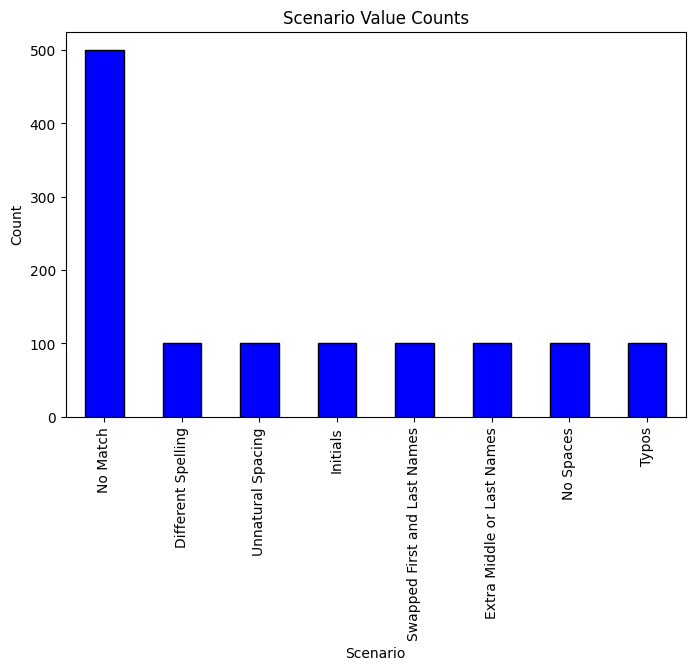

In [5]:
# Count occurrences of each unique value in the 'Scenario' column
scenario_counts = df['Scenario'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 5))
scenario_counts.plot(kind='bar', color='blue', edgecolor='black')

# Labels and title
plt.xlabel('Scenario')
plt.ylabel('Count')
plt.title('Scenario Value Counts')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 56 to 1038
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Scanned Text    1200 non-null   object
 1   Matched Entity  1200 non-null   object
 2   Scenario        1200 non-null   object
 3   Target          1200 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 46.9+ KB


### The list of sanctioned entity or people 

In [7]:
# make a list of the sancton list and tthe text data to be scanned
sanctioned_list = [name.lower() for name in sanction_list['Sanctioned Individuals'].tolist()] 

In [8]:
sanctioned_list[:10]

['charlotte allen',
 'daniel anderson',
 'matthew moore',
 'david brown',
 'ashley taylor',
 'emily davis',
 'sophia clark',
 'michael johnson',
 'sarah williams',
 'olivia lewis']

In [9]:
print(f'The number of the people in sanction list are: {len(sanctioned_list)}')
print(f'The size of the text data to be analysed and find matches is : {df.shape[0]}')

The number of the people in sanction list are: 260
The size of the text data to be analysed and find matches is : 1200


## Preprocessing the Data

### NLP (Natural language Processing)


### Normalization and  Tokenization

First of all we need to apply some NLP steps to have a cleaned data for processing later. the steps are as following:

   - Lowercase all the words in both datasets
   - Remove Punctuations,special characters etc. 
   - Word Tokenization ( break the text in to sequence of words)

This level of cleaning should be enough for this dataset. There ar emore complex works can be done. 




In [10]:
import re
import nltk
nltk.download('wordnet')


def preprocess(text):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    
    # Lowercase the text
    text = text.lower()
    
    # Replace URLs with a space in the text
    text = re.sub(r'http\S+',"",text)

    # Replace everything not a letter with a space
    text = re.sub(r'[^a-zA-Z\s]',"",text)

    # remove the space between characters ( like j o h n to become john)
    text = re.sub(r'\b(?:\w\s)+\w\b', lambda m: m.group(0).replace(" ", ""), text) 
         
    
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JavadGholizadeh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### regex Matching 
The simplest method to find matches from list of sanctione dnames, is to apply regex by looping through the names for each of the scanned text items and flag or alert for more analysis by the company. 

This method is not the best method to use, as it lacks precision in the scenarios mentioned above like typos, or initials and etc. 

I apply this method to see its performance. 

In [11]:
scanned_text = df['Scanned Text'].apply(preprocess).tolist()


# Prepare output lists
matches = []       # 1 if a match was found, otherwise 0
matched_names = [] # The matched name from list2 (or empty string if no match)

# Iterate over each item in scanned_text
for item in scanned_text:
    found = False
    matched_name = ""
    # Check each name from sanctioned names
    for name in sanctioned_list:
        # Split the name into its components (words)
        parts = name.split()
        # Check that every part is present in the item using regex for whole word matching.
        if all(re.search(r'\b' + re.escape(part) + r'\b', item, re.IGNORECASE) for part in parts):
            found = True
            matched_name = name
            break  # Stop at the first full match
    # Append results: 1 if match found, 0 otherwise; and the matched name or empty string.
    matches.append(1 if found else 0)
    matched_names.append(matched_name)


In [12]:
true_names = df['Matched Entity'].apply(preprocess).tolist()
true_names[:10]

['maria kuznetsov',
 'james petrov',
 'vladimir karimov',
 'ahmed ivanov',
 'no match',
 'maria kamali',
 'vladimir azizi',
 'ali kamali',
 'no match',
 'no match']

In [13]:
correct_count = sum(1 for true, pred in zip(true_names, matched_names) if true == pred)
accuracy = (correct_count / len(true_names)) * 100

print("Predicted Matched Names:")
print(f"\nAccuracy: {accuracy:.2f}%")

Predicted Matched Names:

Accuracy: 25.50%


In this method, we have zero false positives and every match is exact match as it checks full name and match if all the name exist in the scanned text.

We miss losts of entities match beacuse of the scenarios given above and we need more complicated method to find those matches. 

The problem with this method is that the accuarcy is low and it can be improved by adding new rules such as:

   - Matching initials with the first letter of names
   - partial matching if there are typos
It needs a lot of rules applied and will be so complex algorithm at the end which will not always cover new scenarios.

It wil also end up having more fasle positives and this is not the aim of the problem statement as we want to reduce false positives with better methods. 

There are new methods can be developed that might help in capturing the names with higher precision:

    - Fuzzy Matching
    - Semantic Similarity between two texts

### Fuzzy Matching:

Fuzzy matching is a technique that identifies similar data, even if it's not an exact match. It's also known as approximate string matching, fuzzy name matching, or fuzzy string matching. 

#### How does it work?
   - Fuzzy matching uses algorithms to compare strings and assign a score to each based on how similar they are. 
   - The closer the scores, the more similar the strings. 
   - Fuzzy matching can handle variations, discrepancies, and errors. 


FuzzyWuzzy is a Python library used for fuzzy string matching, which helps find approximate matches between strings. It is commonly used for tasks like data deduplication, matching user inputs, and comparing text with minor differences by providing a similarity score.

FuzzyWuzzy uses **Levenshtein Distance to calculate the difference between two strings. It provides various ratios, such as Simple Ratio, Token Sort Ratio, and WRatio, to measure the similarity between strings and return a score out of 100.

The Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other


In [14]:
# use df_fuzzy as the copy of the original df
df_fuzzy = df.copy()

In [15]:
# preprocess the target columns (scanned text and also matched entity )  with the preprocess function
df_fuzzy['Scanned Text'] = df_fuzzy['Scanned Text'].apply(preprocess)
df_fuzzy['Matched Entity'] = df_fuzzy['Matched Entity'].apply(preprocess)

In [16]:
df_fuzzy.head()

,Scanned Text,Matched Entity,Scenario,Target
56,tx moreo kuznetsov main st,maria kuznetsov,Different Spelling,1
498,tx james petrov main st,james petrov,Unnatural Spacing,1
371,tx v karimov main st,vladimir karimov,Initials,1
26,tx ahmed ivonov main st,ahmed ivanov,Different Spelling,1
862,tx sophia miller main st,no match,No Match,0


In [17]:
from fuzzywuzzy import process

def get_best_match(text):
    
    best_match, score = process.extractOne(text,sanctioned_list)

    return pd.Series([best_match, score])

# Apply the function to the 'scanned_text' column and create two new columns
df_fuzzy[['closest_match', 'score']] = df_fuzzy['Scanned Text'].apply(get_best_match)

C:\Users\JavadGholizadeh\test-project\test2\env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [18]:
df_fuzzy.head()

,Scanned Text,Matched Entity,Scenario,Target,closest_match,score
56,tx moreo kuznetsov main st,maria kuznetsov,Different Spelling,1,nikolai kuznetsov,86
498,tx james petrov main st,james petrov,Unnatural Spacing,1,james walker,86
371,tx v karimov main st,vladimir karimov,Initials,1,oksana karimov,86
26,tx ahmed ivonov main st,ahmed ivanov,Different Spelling,1,ahmed hassan,86
862,tx sophia miller main st,no match,No Match,0,sophia clark,86


In [19]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, classification_report,confusion_matrix


def evaluate_model(df, threshold):
    """
    Evaluate model performance by computing and plotting the ROC curve,
    and printing precision, recall, and a full classification report.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the columns 'Target' (binary ground truth)
                           and 'score' (continuous similarity scores).
    threshold (float): Threshold value to convert continuous scores to binary predictions.
    """
    # Extract ground truth and similarity scores
    y_true = df['Target']
    y_scores = df['score']

    # Compute ROC curve and AUC
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    print("Area Under the ROC Curve (AUC):", roc_auc)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Convert continuous scores to binary predictions using the specified threshold
    y_pred = (y_scores >= threshold).astype(int)

    # Compute precision and recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)

    # Display full classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))


def get_precision_scores(y_true, y_scores):
    """
    Calculate and plot precision scores for thresholds between start_threshold and end_threshold.

    Parameters:
    y_true (array-like): The binary ground truth labels.
    y_scores (array-like): Continuous scores that will be thresholded to generate predictions.
    start_threshold (float): The starting threshold value.
    end_threshold (float): The ending threshold value.
    num_steps (int): Number of thresholds to evaluate between start_threshold and end_threshold (default is 10).
    """
    # Generate thresholds between the specified start and end values
    precision_scores = []

    # Evaluate precision for each threshold
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        precision = precision_score(y_true, y_pred)
        precision_scores.append(precision)

    return precision_scores

Area Under the ROC Curve (AUC): 0.4775057142857143


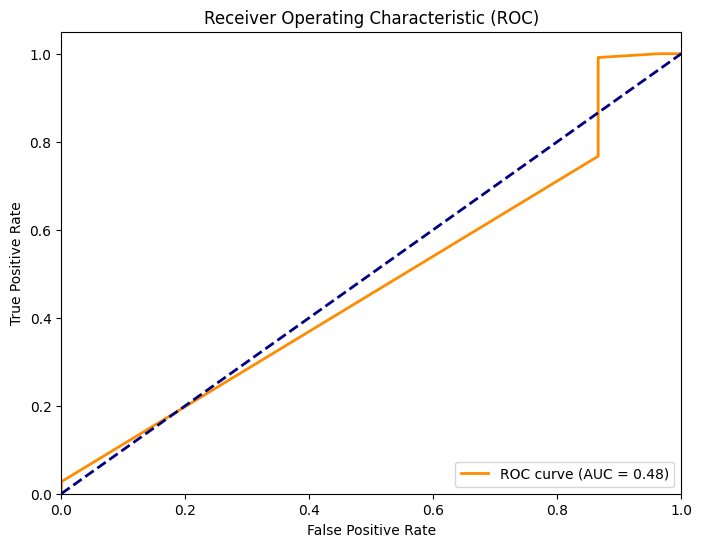

Precision: 0.5833333333333334
Recall: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.58      1.00      0.74       700

    accuracy                           0.58      1200
   macro avg       0.29      0.50      0.37      1200
weighted avg       0.34      0.58      0.43      1200



C:\Users\JavadGholizadeh\test-project\test2\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JavadGholizadeh\test-project\test2\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JavadGholizadeh\test-project\test2\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [20]:
threshold = 50
evaluate_model(df_fuzzy,threshold)

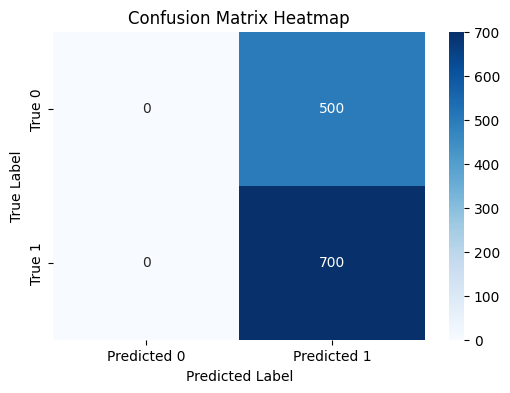

In [21]:
# Create a heatmap visualization
y_scores = df_fuzzy['score']
y_pred = (y_scores >= threshold).astype(int)

y_true = df_fuzzy['Target']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Evaluations:

In this method, while we haven't missed any matches, the high number of false positives results in low precision, which is not ideal.

By choosing different threshods, we cna manage the algorithm decsions. 

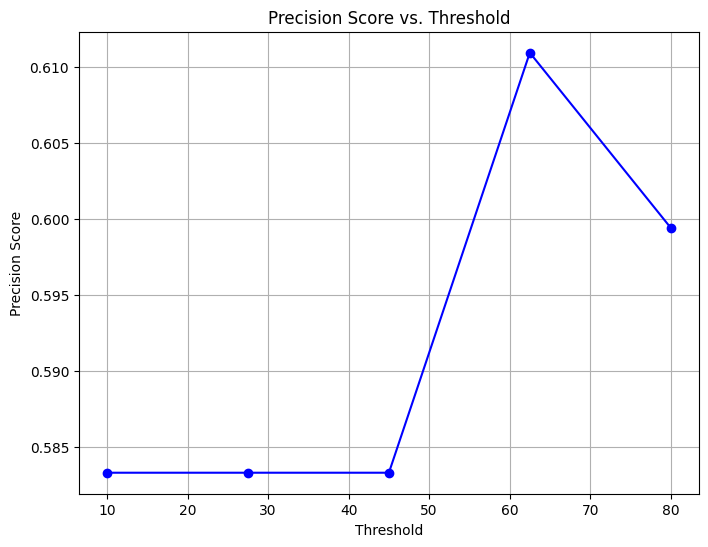

In [22]:
# Plot the precision scores versus thresholds
thresholds = np.linspace(10, 80, 5)

precision_scores = get_precision_scores(y_true,y_scores)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Precision Score')
plt.title('Precision Score vs. Threshold')
plt.grid(True)
plt.show()

### Semantic Similarity:

Semantic similarity delves into the understanding and meaning of the content. the common methods are:


 - Word2Vec
 - Doc2Vec
 - Embeddings

In this text example, We use Doc2Vec but also will use more complex pretraitned tokenization like gpt to compare the results. 


Below is the simple implementation of Doc2Vec:

    1. We first tokenize the words in each document and convert them to lowercase.
    2. We then create TaggedDocument objects required for training the Doc2Vec model. Each document is associated with a unique tag (document ID). This is the paragraph vector.
    3. The parameters (vector_size, window, min_count, workers, epochs) control the model's dimensions, context window size, minimum word count, parallelization, and training epochs.
    4. We then infer a vector representation for a new document that was not part of the training data.
    5. We then calculate the similarity score.

In [23]:
from sklearn.model_selection import train_test_split

# Make a copy of  dataframe
df_word2vec = df.copy()

# Split the dataframe into training and testing sets with stratification on the "Scenario" column
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df_word2vec['Scenario']
)

In [24]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')


# Prepare TaggedDocuments for the scanned texts in the training set
tagged_train = []
for i, text in enumerate(train_df['Scanned Text']):
    words = word_tokenize(text.lower())
    tagged_train.append(TaggedDocument(words=words, tags=[f"scanned_train_{i}"]))

# Prepare TaggedDocuments for the scanned texts in the testing set
tagged_test = []
for i, text in enumerate(test_df['Scanned Text']):
    words = word_tokenize(text.lower())
    tagged_test.append(TaggedDocument(words=words, tags=[f"scanned_test_{i}"]))

# Prepare TaggedDocuments for sanctioned texts (assuming these don't have a Scenario label)
sanctioned_texts = sanctioned_list  # Replace with your actual sanctioned texts list
tagged_sanctioned = []
for i, text in enumerate(sanctioned_texts):
    words = word_tokenize(text.lower())
    tagged_sanctioned.append(TaggedDocument(words=words, tags=[f"sanctioned_{i}"]))
    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JavadGholizadeh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
tagged_training_data = tagged_train + tagged_sanctioned

# Initialize and train the Doc2Vec model on training data only
model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4, epochs=100)

model.build_vocab(tagged_training_data)
model.train(tagged_training_data, total_examples=model.corpus_count, epochs=model.epochs)

# For each scanned text in the test set, infer its vector and retrieve best matching sanctioned text
test_scanned_texts = test_df['Scanned Text'].tolist()
best_matches = []
best_scores = []

for i, text in enumerate(test_scanned_texts):
    # Infer vector for the test scanned text
    scanned_vector = model.infer_vector(word_tokenize(text.lower()))
    
    # Retrieve similar documents from the training corpus
    similar_docs = model.dv.most_similar([scanned_vector], topn=len(model.dv))
    
    # Filter for sanctioned documents only (tags starting with "sanctioned_")
    sanctioned_similarities = [(tag, score) for tag, score in similar_docs if tag.startswith("sanctioned_")]
    
    if sanctioned_similarities:
        best_tag, best_score = sanctioned_similarities[0]
        # Extract the index from the tag (e.g., "sanctioned_1" -> 1)
        best_idx = int(best_tag.split("_")[1])
        best_match = sanctioned_list[best_idx]
    else:
        best_match = None
        best_score = None
    
    best_matches.append(best_match)
    best_scores.append(best_score)

Area Under the ROC Curve (AUC): 0.33121428571428574


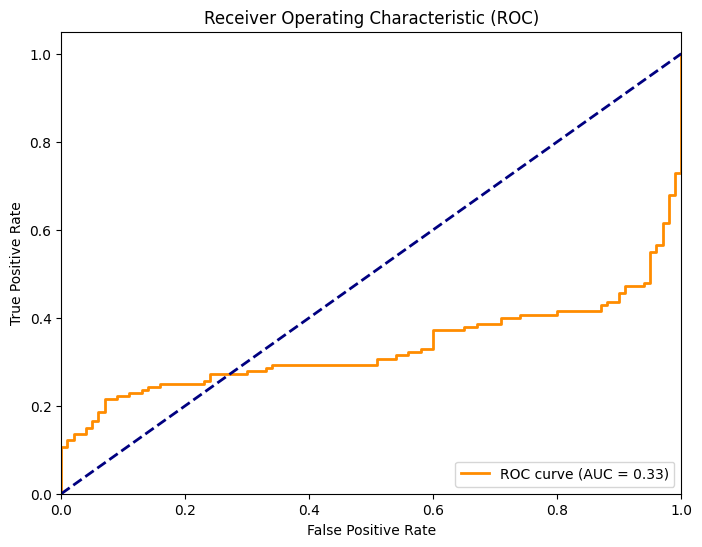

Precision: 0.5305164319248826
Recall: 0.8071428571428572
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.53      0.81      0.64       140

    accuracy                           0.47       240
   macro avg       0.27      0.40      0.32       240
weighted avg       0.31      0.47      0.37       240



In [26]:
df_word2vec = test_df.copy()

# # Create new columns in the dataframe
df_word2vec["closest_match"] = best_matches
df_word2vec["score"] = best_scores

# preprocess the matched entity column 
df_word2vec['Matched Entity'] = df_word2vec['Matched Entity'].apply(preprocess).tolist()

threshold = 0.5
evaluate_model(df_word2vec,threshold)

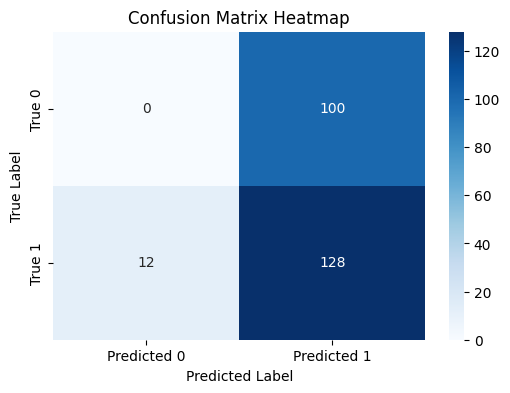

In [27]:
# Create a heatmap visualization
threshold = 0.2
y_scores = df_word2vec['score']
y_pred = (y_scores >= threshold).astype(int)

y_true = df_word2vec['Target']


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

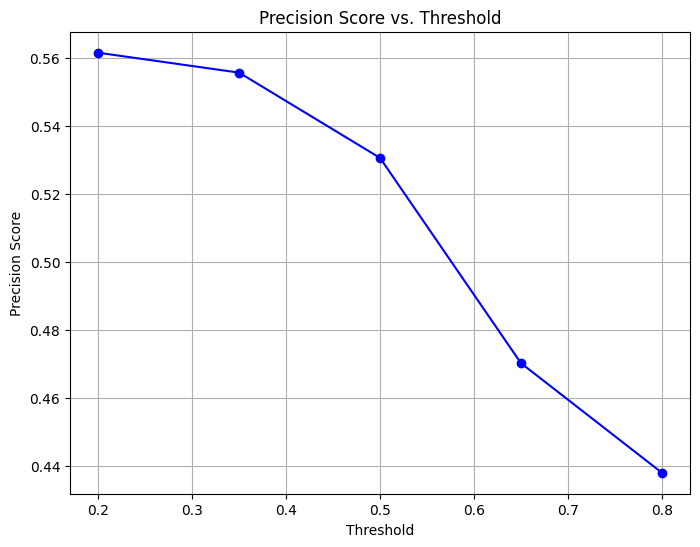

In [28]:
# Plot the precision scores versus thresholds
thresholds = np.linspace(0.2, 0.8, 5)

precision_scores = get_precision_scores(y_true,y_scores)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Precision Score')
plt.title('Precision Score vs. Threshold')
plt.grid(True)
plt.show()

### Embedding Vectors and similarity Measure

One robust method is to use embeddings pretrained on a large dataset and is very robust in finding the semantic meaning of the sentences. for example:

- Bert tokenization
- Sentence Transformers like paraphrase-MiniLM-L6-v2 from Huggingface

This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search (Huggingface). 

I have used  paraphrase-MiniLM-L6-v2 as an example of such embeddings which is powerful in finding the semantic meaning of the context:

In [29]:
df_embeddings = df.copy()

In [30]:
df_embeddings.head()

,Scanned Text,Matched Entity,Scenario,Target
56,TX743210 moreo kuznetsov 89 Main St,Maria Kuznetsov,Different Spelling,1
498,TX364789 j a m e s p e t r o v 89 Main St,James Petrov,Unnatural Spacing,1
371,TX377378 v karimov 86 Main St,Vladimir Karimov,Initials,1
26,TX894723 ahmed ivonov 69 Main St,Ahmed Ivanov,Different Spelling,1
862,TX846062 sophia miller 69 Main St,No Match,No Match,0


In [31]:
from sentence_transformers import SentenceTransformer
from typing import Union

# 
MODEL_NAME = 'paraphrase-MiniLM-L6-v2'

# 
model = SentenceTransformer(MODEL_NAME,device="cpu")

def generate_embeddings(input_data: Union[str, list[str]]) -> np.ndarray: 
    
    '''
    Description - generate embeddings from input data using sentencetransfomer model
    '''
    
    embeddings = model.encode(input_data)
    return embeddings

In [32]:
# preprocess the target columns (scanned text and also matched entity )  with the preprocess function
df_embeddings['Scanned Text'] = df_embeddings['Scanned Text'].apply(preprocess)
df_embeddings['Matched Entity'] = df_embeddings['Matched Entity'].apply(preprocess)

In [33]:
'''
Generate embedding vectors and add the list of embedding vectors to the dataframe
'''

embeddings = generate_embeddings(df_embeddings['Scanned Text'].values)
embeddings = [embed for embed in embeddings]
df_embeddings['embeddings'] = embeddings

In [34]:
df_embeddings.head()

,Scanned Text,Matched Entity,Scenario,Target,embeddings
56,tx moreo kuznetsov main st,maria kuznetsov,Different Spelling,1,"[-0.20876633, 0.43308756, -0.41185877, -0.3858..."
498,tx james petrov main st,james petrov,Unnatural Spacing,1,"[0.20791252, 0.31160054, 0.00087030977, -0.000..."
371,tx v karimov main st,vladimir karimov,Initials,1,"[-0.1225387, 0.49713212, -0.7815399, -0.586804..."
26,tx ahmed ivonov main st,ahmed ivanov,Different Spelling,1,"[0.10901082, 0.6232046, -0.70869076, -0.497687..."
862,tx sophia miller main st,no match,No Match,0,"[0.7457611, -0.71621233, -0.019141367, 0.44204..."


In [35]:
'''
Find the embedding vectors for list of names which are sanctioned. 
'''
name_embeds = generate_embeddings(sanctioned_list)
name_embeds = [embed for embed in name_embeds]

# get a dictioney that have names as keys an embeddings as values. 
name_embeds = dict(zip(sanctioned_list, name_embeds))

In [36]:
dict_keys = list(name_embeds.keys())

dict_embeddings = np.stack(list(name_embeds.values()))  # shape: (n_keys, embedding_dim)

In [37]:
from sklearn.metrics.pairwise import cosine_similarity


# functuion to ge the best match using cosine_similarty beween two vectors. 
def get_best_match(embedding):
    
    # Reshape embedding to 2D array as expected by cosine_similarity
    embedding = embedding.reshape(1, -1)
    
    # Compute cosine similarities with all dictionary embeddings
    sims = cosine_similarity(embedding, dict_embeddings)  # shape: (1, n_keys)
    
    # Find the index of the highest similarity score
    best_index = np.argmax(sims)
    best_score = sims[0][best_index]
    
    # Return the corresponding dictionary key and the best score
    return dict_keys[best_index], best_score



In [38]:
# Apply the function to each embedding and create two new columns

df_embeddings[['closest_match', 'score']] = df_embeddings['embeddings'].apply(
    lambda emb: pd.Series(get_best_match(emb))
)

Area Under the ROC Curve (AUC): 0.78186


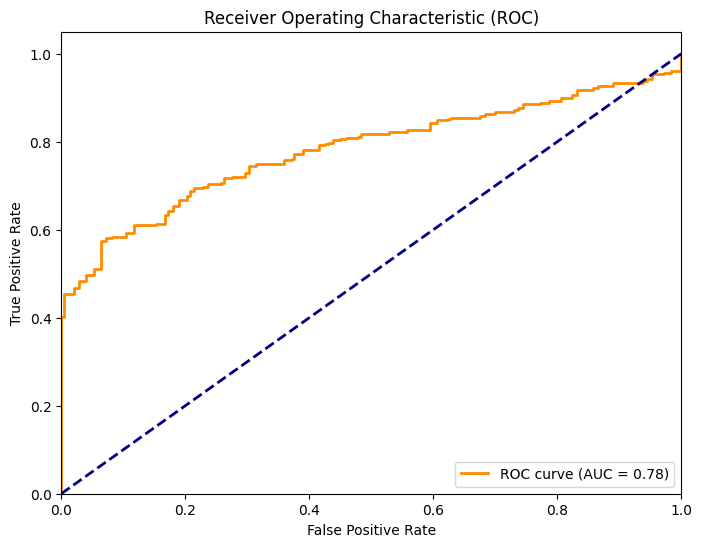

Precision: 0.829136690647482
Recall: 0.6585714285714286
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       500
           1       0.83      0.66      0.73       700

    accuracy                           0.72      1200
   macro avg       0.73      0.73      0.72      1200
weighted avg       0.75      0.72      0.72      1200



In [39]:
threshold = 0.6
evaluate_model(df_embeddings,threshold)

In [40]:
df_embeddings

,Scanned Text,Matched Entity,Scenario,Target,embeddings,closest_match,score
56,tx moreo kuznetsov main st,maria kuznetsov,Different Spelling,1,"[-0.20876633, 0.43308756, -0.41185877, -0.3858...",vladimir kuznetsov,0.700637
498,tx james petrov main st,james petrov,Unnatural Spacing,1,"[0.20791252, 0.31160054, 0.00087030977, -0.000...",james petrov,0.750972
371,tx v karimov main st,vladimir karimov,Initials,1,"[-0.1225387, 0.49713212, -0.7815399, -0.586804...",john karimov,0.694038
26,tx ahmed ivonov main st,ahmed ivanov,Different Spelling,1,"[0.10901082, 0.6232046, -0.70869076, -0.497687...",ahmed hassan,0.580410
862,tx sophia miller main st,no match,No Match,0,"[0.7457611, -0.71621233, -0.019141367, 0.44204...",sophia clark,0.463075
...,...,...,...,...,...,...,...
522,tx annakarimov main st,anna karimov,No Spaces,1,"[0.06351133, 0.018318264, -0.14642927, 0.16627...",anna rahmani,0.530275
217,tx hosseini vladimir main st,vladimir hosseini,Swapped First and Last Names,1,"[-0.02156495, 1.0304133, -0.06418198, -0.34156...",vladimir hosseini,0.708816
340,tx o karimov main st,oksana karimov,Initials,1,"[-0.10732063, 0.626903, -0.78678256, -0.433481...",vladimir karimov,0.693305
473,tx oksana ivanov main st,oksana ivanov,Unnatural Spacing,1,"[-0.01394758, 0.2932445, -0.451859, -0.1554794...",oksana ivanov,0.807532


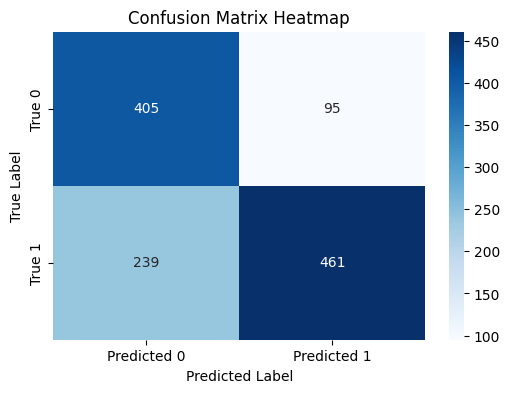

In [41]:
# Create a heatmap visualization
threshold = 0.6
y_scores = df_embeddings['score']
y_pred = (y_scores >= threshold).astype(int)

y_true = df_embeddings['Target']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

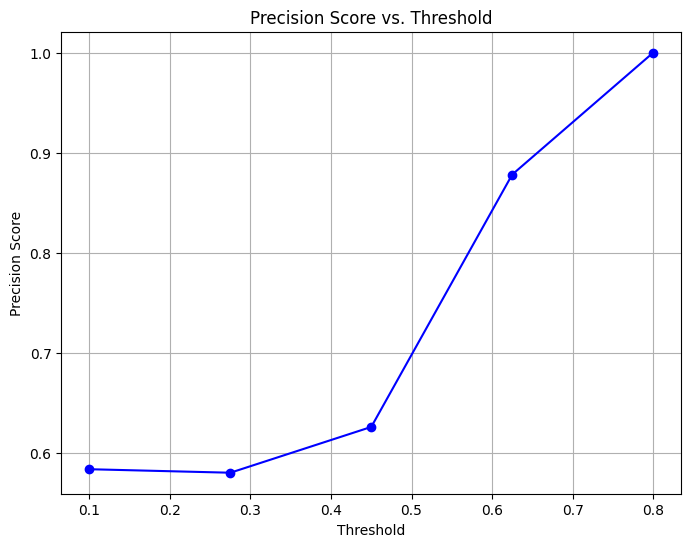

In [42]:
# Plot the precision scores versus thresholds
thresholds = np.linspace(0.1, 0.8, 5)

precision_scores = get_precision_scores(y_true,y_scores)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Precision Score')
plt.title('Precision Score vs. Threshold')
plt.grid(True)
plt.show()

### Compare the results for all three models 

 Based on the scenarios we can evaluate the accuracies for each senario and model. 

In [43]:
# reproduce the predictions 
df_fuzzy['preds'] = df_fuzzy['score'] > 50
df_embeddings['preds'] = df_embeddings['score'] > 0.6

In [44]:

# Categories (scenarios)
categories = ['No Match', 'Typos', 'Extra Middle or Last Names', 'Initials',
       'Different Spelling', 'Unnatural Spacing',
       'Swapped First and Last Names', 'No Spaces']

# Example data for three datasets (replace these with your actual values)
fuzzy_list = (df_fuzzy.groupby('Scenario')['preds'].sum()/df_fuzzy.shape[0]).tolist()
embedding_list =  (df_embeddings.groupby('Scenario')['preds'].sum()/df_embeddings.shape[0]).tolist()

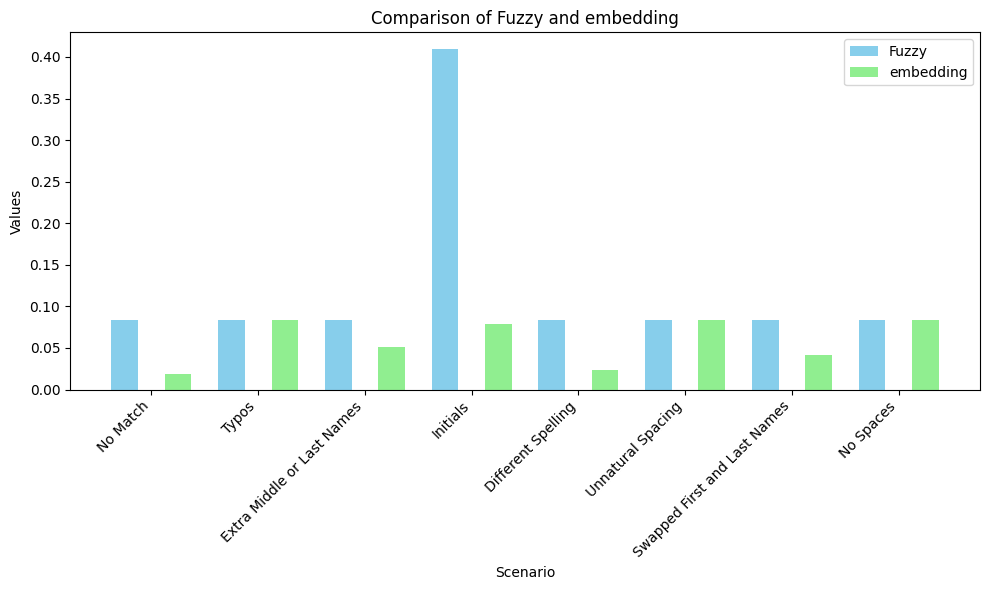

In [45]:
# Prepare the data
data = {
    'Scenario': categories,
    'Fuzzy': fuzzy_list,
    'embedding': embedding_list,
}
df = pd.DataFrame(data)
df.set_index('Scenario', inplace=True)

# Set positions and width for the bars
bar_width = 0.25
index = np.arange(len(df.index))

plt.figure(figsize=(10,6))

# Plot bars for each metric
plt.bar(index - bar_width, df['Fuzzy'], bar_width, label='Fuzzy', color='skyblue')
plt.bar(index + bar_width, df['embedding'], bar_width, label='embedding', color='lightgreen')

# Add labels and title
plt.xlabel('Scenario')
plt.ylabel('Values')
plt.title('Comparison of Fuzzy and embedding')
plt.xticks(index, df.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluations:


    1- On more complex scenarios and larger real dataset the evaluation results will be different, as it is likely to see more consistency in similarity matching using embeddings. 

    - Two methods fuzzy matching and embeddings also can be combined to create more robust results by giving weights and the final algorithm can be used in  production environment after testing on large corpus of data. 

    2- LLM embeddings are not specific for this task, as they are not trained specifically for name matching, so fine-tuning on large dataset can help them distingush names with better performance than above. 

    3- We can also add another layer as rule to match different feature like date of birth to confirm matches and then flag them for extra check. 

A different approach is to use a Siamese Neural Network for name matching. This deep learning method learns to map names to an embedding space where similar names (even if spelled differently) end up close together.

Other methods, such as using ensemble classifiers (e.g., Random Forests) with string similarity features (like Levenshtein distance or Jaro-Winkler score), are also popular for record linkage and name matching tasks.


### Conclusion:

This approach combines robust preprocessing, fuzzy matching techniques, and potential machine learning to handle the wide range of name variations encountered in sanction screening. By carefully tuning thresholds and testing on diverse cases, the system can significantly reduce false positives while ensuring legitimate alerts are caught, thereby improving the efficiency and accuracy of the screening process.

Depending on the speed of the algorithm in real-time also is important in choosing the best method as the method sometimes need to be fast in analysing the data, specially in real-time inferencing. 